# Predicción de costo de Seguros médico con Machine Learning

In [63]:
#charges: costo de seguro medico (target a evaluar)
#sex: female or male
#age: edad
#region: southwest-northwest-southeast-northeast
#smoker:tabaquismo (yes or no)
#bmi indice de masa corporal kg/m2

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os 


from sklearn import metrics
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

In [4]:
os.chdir('D:/MiniProyectos_Python/Prediccion_CostoSeguro')

In [5]:
miArchivo='insurance.csv'
df=pd.read_csv(miArchivo)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.shape

(1338, 7)

In [9]:
df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [10]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Contamos con 0 valores nulos o perdidos

## Analisis exploratorio de datos

In [11]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

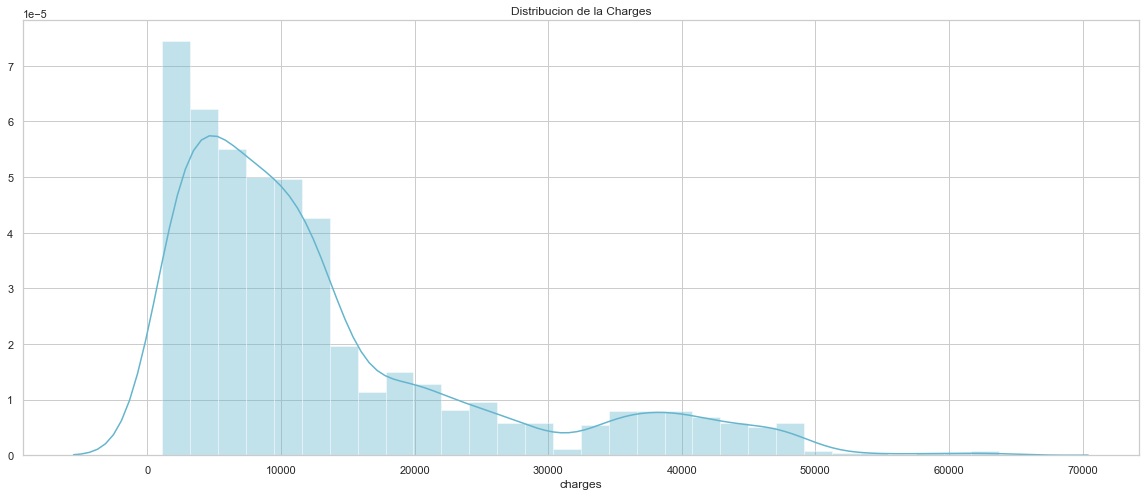

In [12]:
sns.set(style='whitegrid')
fig,ax=plt.subplots(1,1,figsize=(20,8))
ax=sns.distplot(df['charges'],kde=True,color='c')
plt.title('Distribucion de la Charges')
plt.show()

Esta distribución está sesgada a la derecha, para poder hacerla más cercana a una distribución normal podemos aplicar log natural

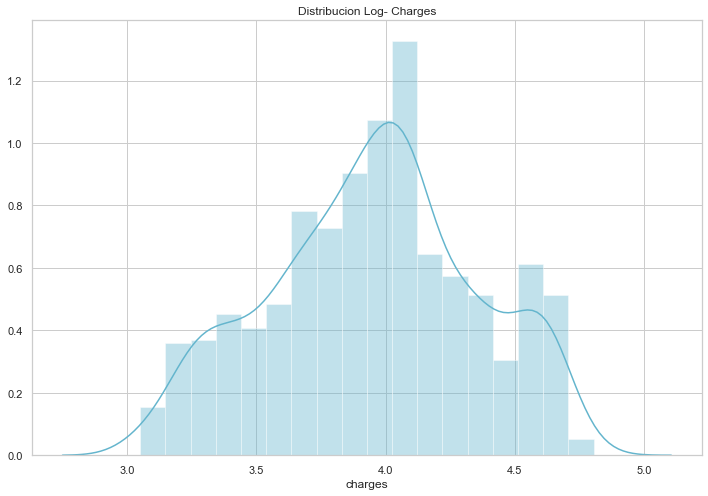

In [13]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax=sns.distplot(np.log10(df['charges']),kde=True,color='c')
plt.show()

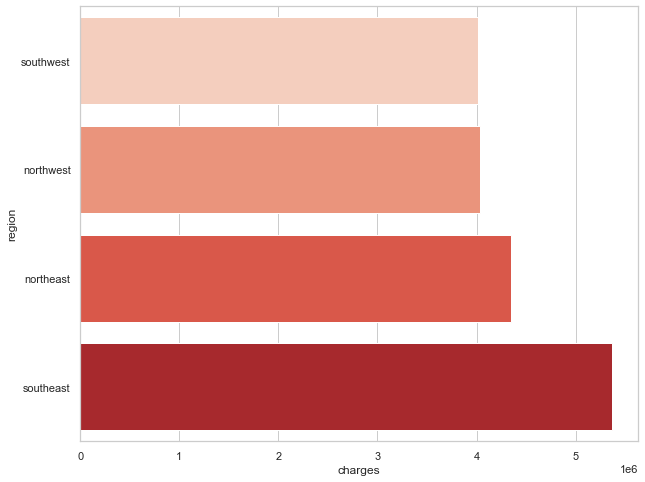

In [16]:
charges=df['charges'].groupby(df.region).sum().sort_values(ascending=True)
fig,ax=plt.subplots(1,1,figsize=(10,8))
ax=sns.barplot(charges.head(),charges.head().index,palette='Reds')

En general se puede observar que los cargos médicos más bajos se encuentran en el southwest(sur-oeste) y los más altos en el southeast(sur-este). Teniendo en cuenta ciertos factores (sexo, tabaquismo, tener hijos) veamos como cambia por region

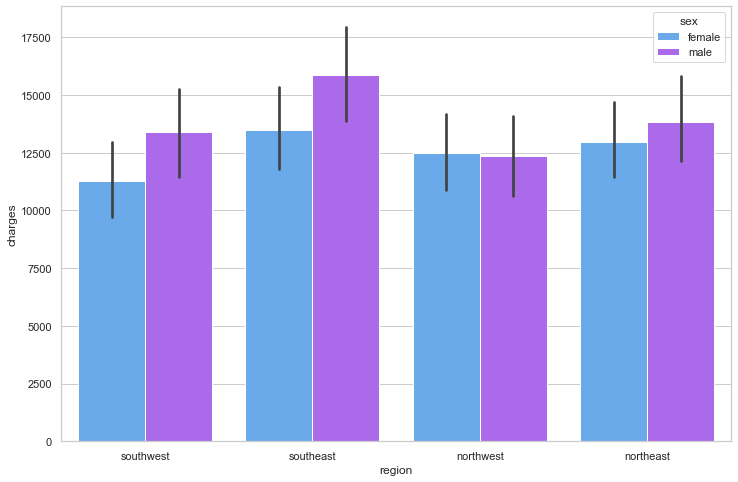

In [22]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax = sns.barplot(x='region',y='charges',hue='sex',data=df,palette='cool')

En la mayoria de las regiones, se puede observar que los hombres suelen tener un charges más elevado a comparación con las mujeres

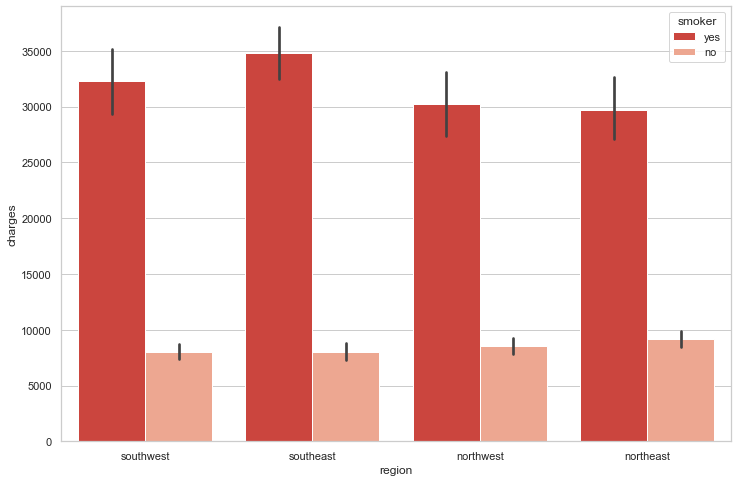

In [24]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax = sns.barplot(x='region',y='charges',hue='smoker',data=df,palette='Reds_r')

Las personas que fuman tienen el costo de seguro médico mucho más alta en cada una de las regiones (esta variable es muy importante para determinar el costo de seguro). Además se puede ver que las personas que más fuman se encuentran en el sur-oeste, las personas que menos fuman se encuentran en el northeast pero con el gráfico de géneros se ve que a nivel de genero, en el northeast tienden a tener cargos de seguro más altos que en todo el norte(southwest-northwest)

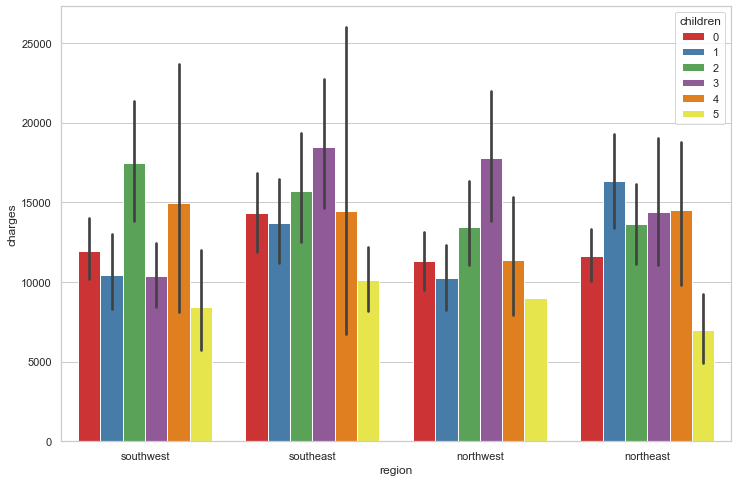

In [25]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax = sns.barplot(x='region',y='charges',hue='children',data=df,palette='Set1')

Analizando gastos médicos por edad,IMC y niños segun el factor de tabaquismo

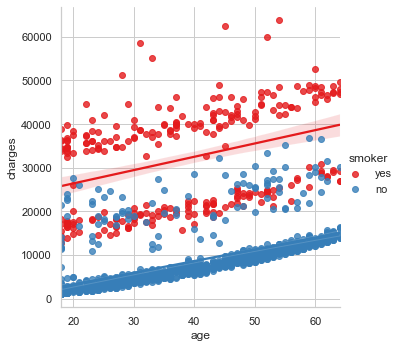

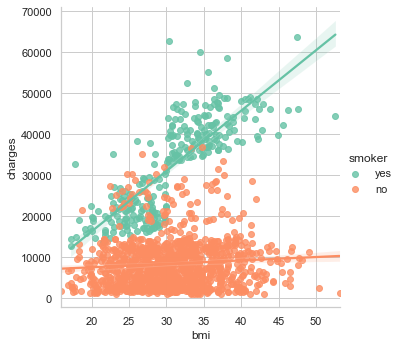

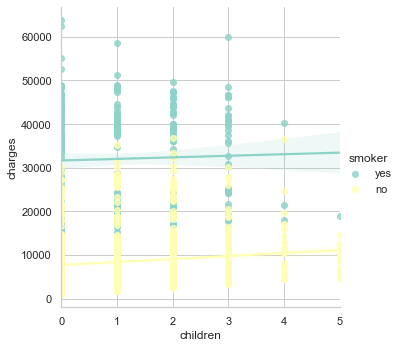

In [26]:
ax=sns.lmplot(x='age',y='charges',data=df,hue='smoker',palette='Set1')
ax=sns.lmplot(x='bmi',y='charges',data=df,hue='smoker',palette='Set2')
ax=sns.lmplot(x='children',y='charges',data=df,hue='smoker',palette='Set3')

Fumar tiene el mayor impacto en los costos médicos, aunque los costos aumentan con la edad, el indice de masa corporal y los niños. Además, las personas que tienen hijos generalmente fuman menos, lo que tambien muestran las siguientes grafico de violin

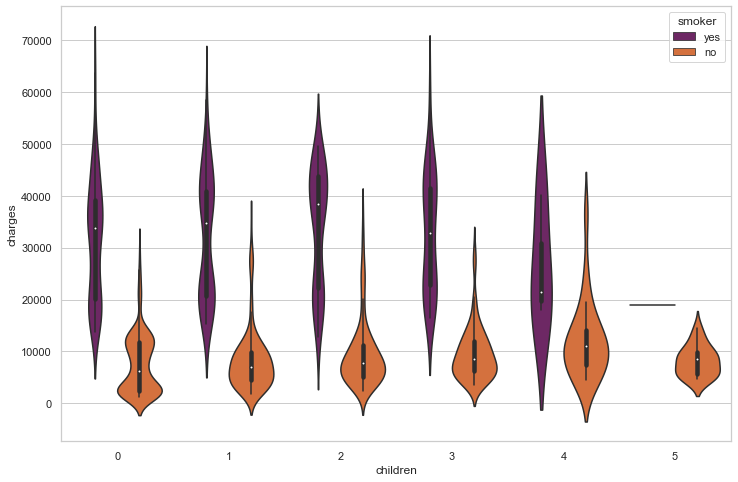

In [27]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax = sns.violinplot(x='children',y='charges',hue='smoker',data=df,orient='v',palette='inferno')

In [28]:
##conversion de variables categoricas en etiquetas
df[['sex','smoker','region']]=df[['sex','smoker','region']].astype('category')

In [33]:
df.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

In [34]:
#Convertir las variables categoricas en numericas usando LabelEncoder
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
label.fit(df.sex.drop_duplicates())
df.sex=label.transform(df.sex)
label.fit(df.smoker.drop_duplicates())
df.smoker=label.transform(df.smoker)
label.fit(df.region.drop_duplicates())
df.region=label.transform(df.region)
df.dtypes

age           int64
sex           int32
bmi         float64
children      int64
smoker        int32
region        int32
charges     float64
dtype: object

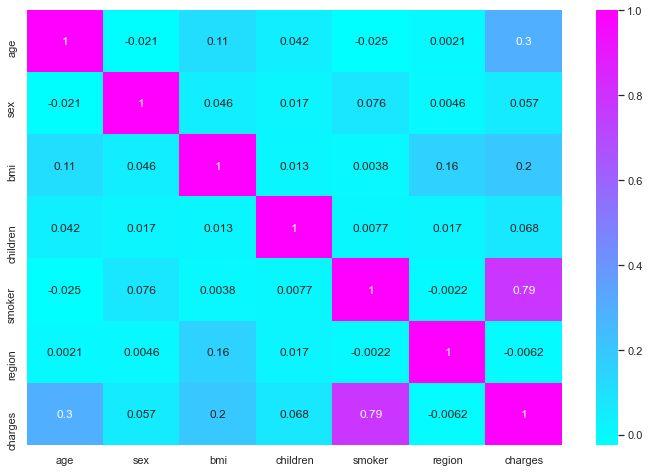

In [37]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax = sns.heatmap(df.corr(),annot=True,cmap='cool')

Solo la variable smoker tiene una correlación fuerte

# Regresion Lineal

In [38]:
x=df.drop(['charges'],axis=1)
y=df['charges']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
lin_reg = LinearRegression()
reg_lineal=lin_reg.fit(x_train,y_train)
print('Intercepto: %.3f' %lin_reg.intercept_)
print(lin_reg.coef_)
print('score: %.3f' %lin_reg.score(x_test,y_test))

Intercepto: -11661.984
[  253.99185244   -24.32455098   328.40261701   443.72929547
 23568.87948381  -288.50857254]
score: 0.800


In [43]:
#haciendo las predicciones con el conjunto de prueba
y_pred_lineal=reg_lineal.predict(x_test)
print("Error Absoluto medio:", metrics.mean_absolute_error(y_test,y_pred_lineal))
print("Error medio cuadrado:",metrics.mean_squared_error(y_test,y_pred_lineal))
print("Raiz del Error cuadratico medio:",np.sqrt(metrics.mean_squared_error(y_test,y_pred_lineal)))
#El coeficiente de determinacion: 1 indica perfección en la predicción del modelo
print('Coeficiente de determinación: %.2f'%r2_score(y_test,y_pred_lineal))

Error Absoluto medio: 3930.333273901141
Error medio cuadrado: 31845929.13415943
Raiz del Error cuadratico medio: 5643.219748880902
Coeficiente de determinación: 0.80


El resultado que se obtiene hasta el momento es bueno pero se podria mejorar un poco si reducimos algunas caracteristicas sin importancia, se probará esto más adelante

# Regresión Ridge

In [45]:
Ridge=Ridge(alpha=0.5)
model_ridge=Ridge.fit(x_train,y_train)
print(Ridge.intercept_)
print(Ridge.coef_)
print(Ridge.score(x_test,y_test))

-11643.440927495818
[ 2.53893751e+02 -2.15112284e+01  3.28339566e+02  4.44238477e+02
  2.35009674e+04 -2.89027871e+02]
0.799698963206314


In [46]:
#haciendo las predicciones con el conjunto de prueba
y_pred_ridge=model_ridge.predict(x_test)
print("Error Absoluto medio:", metrics.mean_absolute_error(y_test,y_pred_ridge))
print("Error medio cuadrado:",metrics.mean_squared_error(y_test,y_pred_ridge))
print("Raiz del Error cuadratico medio:",np.sqrt(metrics.mean_squared_error(y_test,y_pred_ridge)))
#El coeficiente de determinacion: 1 indica perfección en la predicción del modelo
print('Coeficiente de determinación: %.2f'%r2_score(y_test,y_pred_ridge))

Error Absoluto medio: 3936.645077764159
Error medio cuadrado: 31873896.438061956
Raiz del Error cuadratico medio: 5645.697161384231
Coeficiente de determinación: 0.80


Comparando los resultados de las metricas obtenidas podemos comprobar que hasta el momento la **Regresión Lineal** me brinda mejores resultados

# Regresión Lasso

In [48]:
Lasso=Lasso(alpha=0.2,fit_intercept=True,normalize=False,precompute=False,max_iter=1000, tol=0.0001,
            warm_start=False,positive=False,random_state=None,selection='cyclic')
model_lasso=Lasso.fit(x_train,y_train)
print(Lasso.intercept_)
print(Lasso.coef_)
print(Lasso.score(x_test,y_test))

-11661.838929039537
[ 2.53991436e+02 -2.34569821e+01  3.28389438e+02  4.43587436e+02
  2.35676136e+04 -2.88340296e+02]
0.7998690236224705


In [49]:
#haciendo las predicciones con el conjunto de prueba
y_pred_lasso=model_lasso.predict(x_test)
print("Error Absoluto medio:", metrics.mean_absolute_error(y_test,y_pred_lasso))
print("Error medio cuadrado:",metrics.mean_squared_error(y_test,y_pred_lasso))
print("Raiz del Error cuadratico medio:",np.sqrt(metrics.mean_squared_error(y_test,y_pred_lasso)))
#El coeficiente de determinacion: 1 indica perfección en la predicción del modelo
print('Coeficiente de determinación: %.2f'%r2_score(y_test,y_pred_lasso))

Error Absoluto medio: 3930.4787565896063
Error medio cuadrado: 31846834.73044648
Raiz del Error cuadratico medio: 5643.299985863456
Coeficiente de determinación: 0.80


Comparando los resultados de las metricas obtenidas podemos comprobar que hasta el momento el modelo **Regresión Lasso** me brinda mejores resultados que la **Regresión Ridge**, y resultados mucho más similares a la **Regresión Lineal**, aún asi, por muy pocos decimales de error, la **Regresión Lineal** nos sigue dando mejores resultados

# Random Forest

In [51]:
x=df.drop(['charges'],axis=1)
y=df.charges
Rfr=rfr(n_estimators=100,criterion='mse',random_state=1,n_jobs=-1)
model_rfr=Rfr.fit(x_train,y_train)
x_test_pred=Rfr.predict(x_test)
x_train_pred=Rfr.predict(x_train)

print('MSE data entrenamiento: %.3f,MSE data testeo: %.3f' %
      (metrics.mean_squared_error(x_train_pred,y_train),
       metrics.mean_squared_error(x_test_pred,y_test)))

print('R2 data entrenamiento: %.3f,R2 data testeo: %.3f' %
      (metrics.r2_score(y_train,x_train_pred,y_train),
       metrics.r2_score(y_test,x_test_pred,y_test)))

MSE data entrenamiento: 3635087.011,MSE data testeo: 19766481.085
R2 data entrenamiento: 0.971,R2 data testeo: 0.877


In [52]:
#haciendo las predicciones con el conjunto de prueba
y_pred_rfr=model_rfr.predict(x_test)
print("Error Absoluto medio:", metrics.mean_absolute_error(y_test,y_pred_rfr))
print("Error medio cuadrado:",metrics.mean_squared_error(y_test,y_pred_rfr))
print("Raiz del Error cuadratico medio:",np.sqrt(metrics.mean_squared_error(y_test,y_pred_rfr)))
#El coeficiente de determinacion: 1 indica perfección en la predicción del modelo
print('Coeficiente de determinación: %.2f'%r2_score(y_test,y_pred_rfr))

Error Absoluto medio: 2651.0713146089056
Error medio cuadrado: 19766481.08478538
Raiz del Error cuadratico medio: 4445.951088888111
Coeficiente de determinación: 0.88


Comparando los resultados de las metricas obtenidas podemos comprobar que hasta el momento el modelo **Random Forest** me brinda mejores resultados

# Visualizando el comportamiento de los datos predichos con los datos actuales

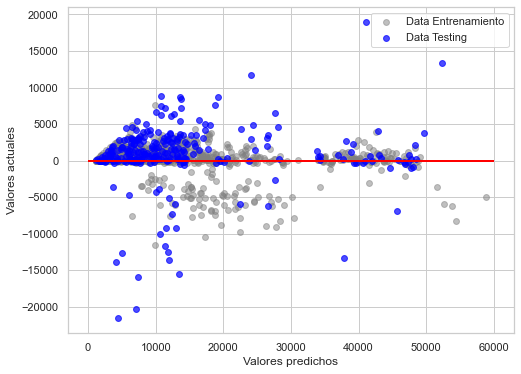

In [56]:
plt.figure(figsize=(8,6))

plt.scatter(x_train_pred,x_train_pred - y_train,
          c='gray',marker='o',s=35,alpha=0.5,
          label='Data Entrenamiento')
plt.scatter(x_test_pred,x_test_pred - y_test,
          c='blue',marker='o',s=35,alpha=0.7,
          label='Data Testing')
plt.xlabel('Valores predichos')
plt.ylabel('Valores actuales')
plt.legend(loc='upper right')
plt.hlines(y=0,xmin=0,xmax=60000,lw=2, color='red')
plt.show()

# Estimamos la importancia de las caracteristicas evaluadas en el modelo Random Forest

Ranking de Características importantes
1.smoker(0.601678)
2.bmi(0.218724)
3.age(0.136971)
4.children(0.021047)
5.region(0.015208)
6.sex(0.006371)


<BarContainer object of 6 artists>

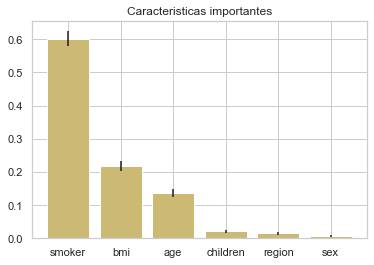

In [57]:
print('Ranking de Características importantes')
importancia=Rfr.feature_importances_
std=np.std([tree.feature_importances_ for tree in Rfr.estimators_],axis=0)
indices = np.argsort(importancia)[::-1]
variables=['age','sex','bmi','children','smoker','region']
importancia_list=[]
for f in range(x.shape[1]):
    variable=variables[indices[f]]
    importancia_list.append(variable)
    print("%d.%s(%f)"%(f+1,variable,importancia[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Caracteristicas importantes")
plt.bar(importancia_list,importancia[indices],color="y",yerr=std[indices],align="center")
plt.show()

# Regresión Polinomial

In [60]:
x=df.drop(['charges','sex','region'],axis=1)
y=df.charges
pol = PolynomialFeatures(degree=2)
x_pol=pol.fit_transform(x)
x_train,x_test,y_train,y_test = train_test_split(x_pol,y,test_size=0.2,random_state=0)
Pol_reg=LinearRegression()
Pol_reg.fit(x_train,y_train)
y_train_pred= Pol_reg.predict(x_train)
y_test_pred = Pol_reg.predict(x_test)
print(Pol_reg.intercept_)
print(Pol_reg.coef_)
print(Pol_reg.score(x_test,y_test))

-5325.881705253059
[ 0.00000000e+00 -4.01606591e+01  5.23702019e+02  8.52025026e+02
 -9.52698471e+03  3.04430186e+00  1.84508369e+00  6.01720286e+00
  4.20849790e+00 -9.38983382e+00  3.81612289e+00  1.40840670e+03
 -1.45982790e+02 -4.46151855e+02 -9.52698471e+03]
0.8812595703345225


In [61]:
print("Error Absoluto medio:", metrics.mean_absolute_error(y_test,y_test_pred))
print("Error medio cuadrado:",metrics.mean_squared_error(y_test,y_test_pred))
print("Raiz del Error cuadratico medio:",np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))
#El coeficiente de determinacion: 1 indica perfección en la predicción del modelo
print('Coeficiente de determinación: %.2f'%r2_score(y_test,y_test_pred))

Error Absoluto medio: 2824.495045477655
Error medio cuadrado: 18895160.098780446
Raiz del Error cuadratico medio: 4346.856346692452
Coeficiente de determinación: 0.88


In [62]:
y_test_pred=Pol_reg.predict(x_test)
##Comparing the actual output values with the predicted values
df=pd.DataFrame({'Actual':y_test,'Prediccion':y_test_pred})
df

,Actual,Prediccion
578,9724.53000,12101.156323
610,8547.69130,10440.782266
569,45702.02235,48541.022951
1034,12950.07120,14140.067522
198,9644.25250,8636.235727
...,...,...
1084,15019.76005,16712.196281
726,6664.68595,8654.565461
1132,20709.02034,12372.050609
725,40932.42950,41465.617268


Comparando los resultados de las metricas obtenidas podemos comprobar que el modelo **Random Forest** me brinda mejores resultados que la **Regresión Polinomial**, por lo tanto el modelo más optimo a utilizar en este caso de predicción fue el **Random Forest**